# Monocular Depth Prediction on KITTI Eigen Split

#### The basic code was taken from - https://github.com/shuuchen/depth_eigen/blob/master/depth_eigen.ipynb

#### Original work has not released a github code

In [ ]:
!pip -q install tqdm
from tqdm.auto import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Mount Google Drive

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# replace with your own preferred path
DRIVE_PATH = '/content/drive/MyDrive/kitti/kitti-eigen-split-dataset'

# create the directory if it doesn't exist
import os
os.makedirs(DRIVE_PATH, exist_ok=True)

# set root folder for the dataset loader
DATA_ROOT = DRIVE_PATH

## Download the Kitti Eigen Split dataset from Kaggle

In [ ]:
# install kaggle cli
!pip install kaggle --quiet

In [ ]:
# environment variables directly
from google.colab import userdata

In [ ]:
!pip -q install kaggle

import getpass, os
os.environ['KAGGLE_USERNAME'] = userdata.get('kaggle_user_name') # set kaggle user name
os.environ['KAGGLE_KEY'] = userdata.get('kaggle_key') # set Kaggle key

### Download and unzip the dataset

In [ ]:
# download + unzip
!kaggle datasets download -d awsaf49/kitti-eigen-split-dataset -p "$DRIVE_PATH" --unzip

# verify contents
!ls -lah "$DRIVE_PATH"

### Dataset formatting

In [ ]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

KITTI_W, KITTI_H = 576, 172  # output image size (W,H)


class KittiEigenSplitDataset(Dataset):
    """
    Correct KITTI Eigen split dataset loader.
    IMPORTANT FIXES:
        ✓ Correct 16-bit depth handling
        ✓ Convert depth to meters BEFORE resize
        ✓ Use cv2.INTER_NEAREST for sparse depth
    """

    def __init__(self, root_dir, split='train', transform=None, max_pairs=None, camera='image_02'):
        self.root = Path(root_dir)
        self.split = split
        self.transform = transform
        self.camera = camera
        self.pairs = []

        split_root = self.root / split
        if not split_root.exists():
            raise FileNotFoundError(f"Split folder not found: {split_root}")

        # Collect RGB / depth pairs
        for date_dir in sorted([p for p in split_root.iterdir() if p.is_dir()]):
            for drive_dir in sorted([p for p in date_dir.iterdir() if p.is_dir() and p.name.endswith('_sync')]):

                rgb_dir = drive_dir / self.camera / "data"
                gt_dir  = drive_dir / "proj_depth" / "groundtruth" / self.camera

                if not rgb_dir.exists():
                    continue

                rgb_files = sorted(rgb_dir.glob("*.png"))
                if not rgb_files:
                    continue

                # If no GT, fall back to Velodyne raw depth
                use_velodyne = False
                if not gt_dir.exists() or len(list(gt_dir.glob("*.png"))) == 0:
                    gt_raw = drive_dir / "proj_depth" / "velodyne_raw" / self.camera
                    if gt_raw.exists() and len(list(gt_raw.glob("*.png"))) > 0:
                        gt_dir = gt_raw
                        use_velodyne = True
                    else:
                        continue

                # Match filenames
                for rgb_path in rgb_files:
                    fname = rgb_path.name
                    depth_path = gt_dir / fname

                    if depth_path.exists():
                        self.pairs.append((rgb_path, depth_path, use_velodyne))

                    if max_pairs is not None and len(self.pairs) >= max_pairs:
                        break

                if max_pairs is not None and len(self.pairs) >= max_pairs:
                    break

            if max_pairs is not None and len(self.pairs) >= max_pairs:
                break

        if len(self.pairs) == 0:
            raise RuntimeError(f"No RGB/Depth pairs found in {split_root} using {self.camera}")

        # Standard ImageNet normalization
        self.norm = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rgb_path, depth_path, _ = self.pairs[idx]

        # Load RGB
        rgb = Image.open(rgb_path).convert("RGB")
        rgb = rgb.resize((KITTI_W, KITTI_H), Image.BILINEAR)

        rgb_t = self.to_tensor(rgb)
        rgb_t = self.norm(rgb_t)

        # Load depth (CORRECTED IMPLEMENTATION)
        # Load original 16-bit PNG (no resize here!)
        depth_raw = np.array(Image.open(depth_path), dtype=np.uint16)

        # Convert to meters BEFORE resize
        depth_np = depth_raw.astype(np.float32) / 256.0

        # Resize in float space (correct!)
        depth_np = cv2.resize(depth_np, (KITTI_W, KITTI_H), interpolation=cv2.INTER_NEAREST)

        # Convert to torch tensor [1, H, W]
        depth_t = torch.from_numpy(depth_np).unsqueeze(0)

        # Mask invalid depth (zeros)
        depth_t[depth_t <= 0] = 0.0

        return rgb_t, depth_t

### Eigen (2014) Architecture

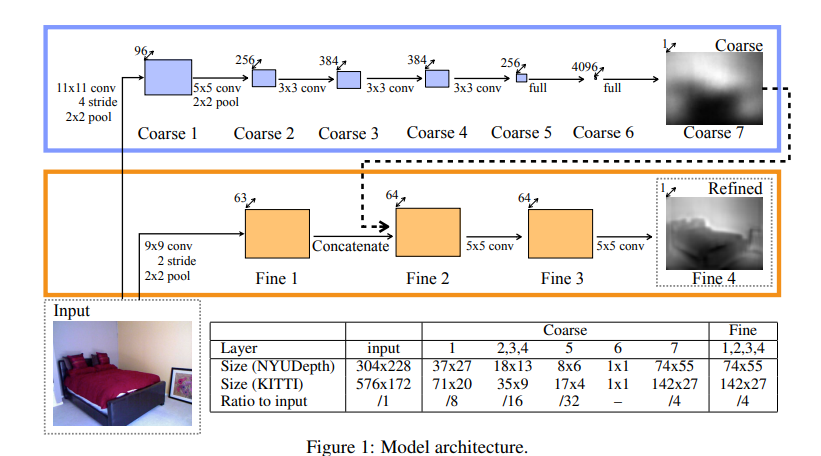

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# input resolution = 576×172 (Width × Height)
# coarse output feature map size ≈ 142×27 = 1/4 of input

COARSE_OUT_W, COARSE_OUT_H = 142, 27


# Global (coarse) network — learns overall scene structure and provides a middle representation
class GlobalCoarseNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Coarse conv stack (paper: 11x11 s4, pool; 5x5; pool; 3x3; 3x3; 3x3; pool)

        # Conv1: input channels=3 (RGB), output=96 filters
        # Large kernel (11x11) with stride=4 quickly reduces spatial size
        self.conv1 = nn.Conv2d(3,   96, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2: input channels=96, output=256 filters
        # Uses 5x5 kernel with padding=2 to preserve spatial shap
        self.conv2 = nn.Conv2d(96,  256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3–Conv5: deeper feature extraction
        # 256→384→384→256 filters progressively expand and compress features
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adaptive pooling → fixes feature map to [256, 4, 17]
        # Ensures constant size regardless of input dimensions
        self.adapt = nn.AdaptiveAvgPool2d((4, 17))  # (H=4, W=17)

        # Fully connected (dense) layers for depth regression
        # Input: 256 feature maps * 4 * 17 spatial = 17408 features
        self.fc1 = nn.Linear(256 * 4 * 17, 4096)         # compress global context
        self.drop = nn.Dropout(p=0.5)                    # dropout regularization
        self.fc2 = nn.Linear(4096, COARSE_OUT_H * COARSE_OUT_W) # outputs flattened 27×142 map (1/4 of input size)

    def forward(self, x):
        # forward pass through conv + pool layers

        # x: [batch_size, 3, height, width]
        x = F.relu(self.conv1(x))      # [batch_size, 96, H/4, W/4]
        x = self.pool1(x)              # [batch_size, 96, H/8, W/8]

        x = F.relu(self.conv2(x))      # [batch_size, 256, H/8, W/8]
        x = self.pool2(x)              # [batch_size, 256, H/16, W/16]

        x = F.relu(self.conv3(x))      # [batch_size, 384, H/16, W/16]
        x = F.relu(self.conv4(x))      # [batch_size, 384, H/16, W/16]
        x = F.relu(self.conv5(x))      # [batch_size, 256, H/16, W/16]
        x = self.pool5(x)              # [batch_size, 256, H/32, W/32]

        x = self.adapt(x)              # [batch_size, 256, 4, 17]
        x = x.flatten(1)               # [batch_size, 256*4*17]
        x = F.relu(self.fc1(x))        # [batch_size, 4096]
        x = self.drop(x)               # [batch_size, 27*142]
        x = self.fc2(x)
        x = x.view(-1, 1, COARSE_OUT_H, COARSE_OUT_W)  # [batch_size, 1, 27, 142]
        return x

In [ ]:
class LocalFineNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Local (fine) network — refines coarse prediction with fine image details

        # Conv1: input=3 (RGB), output=63 filters
        # Large 9x9 kernel with stride=2 reduces spatial size and captures local texture cues
        self.conv1 = nn.Conv2d(3, 63, kernel_size=9, stride=2, padding=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        # After pooling, coarse depth (1 channel) is concatenated → total 64 channels
        # Conv2: input=64, output=64 filters, 5x5 kernel for joint RGB-depth refinement
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)

        # Conv3: input=64, output=64 filters, another 5x5 conv for deeper local refinement
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)

        # Conv4: input=64, output=1 filter, 3x3 kernel → final refined depth map
        self.conv4 = nn.Conv2d(64, 1,  kernel_size=3, stride=1, padding=1)

    def forward(self, image, coarse):
        # image:  [batch_size, 3, height, width]   [batch_size, 3, 172, 576]
        # coarse: [batch_size, 1, 27, 142]         from global coarse network


        B, C, H, W = image.shape

        # Upsample coarse prediction to full image resolution
        coarse_up_full = F.interpolate(coarse, size=(H, W), mode='bilinear', align_corners=False)

        # Extract local image features
        x = F.relu(self.conv1(image))   # [batch_size, 63, H/2, W/2]
        x = self.pool1(x)               # [batch_size, 63, H/4, W/4]

        # Resize coarse to match feature map and concatenate with RGB features
        coarse_feat = F.interpolate(coarse_up_full, size=(x.shape[2], x.shape[3]),
                                    mode='bilinear', align_corners=False)  # [batch_size, 1, H/4, W/4]

        x = torch.cat([x, coarse_feat], dim=1)   # [batch_size, 64, H/4, W/4]

        # Local refinement through deeper 5x5 conv layers
        x = F.relu(self.conv2(x))       # [batch_size, 64, H/4, W/4]
        x = F.relu(self.conv3(x))       # [batch_size, 64, H/4, W/4]
        x = self.conv4(x)               # [batch_size, 1,  H/4, W/4]

         # Output: refined depth map at 1/4 input resolution
        return x

In [ ]:
class EigenDepthModel(nn.Module):
    def __init__(self):
        super().__init__()
        # combines global (coarse) and local (fine) networks
        self.global_net = GlobalCoarseNet()
        self.local_net  = LocalFineNet()

    def forward(self, x):
         # x: [batch_size, 3, height, width]
        coarse = self.global_net(x)                   # [batch_size, 1, 27, 142]
        fine   = self.local_net(x, coarse)            # [batch_size, 1, H/4, W/4]
        return coarse, fine                           # returns both outputs

## Loss Function (Scale Invariant Logarithmic Loss)

$$
\mathcal{L}_{\text{SILog}} =
\frac{1}{N} \sum_{i=1}^{N} d_i^2
- \lambda \left( \frac{1}{N} \sum_{i=1}^{N} d_i \right)^2,
\quad
d_i = \log(\hat{y}_i + \epsilon) - \log(y_i + \epsilon)
$$

**Where:**
- $\hat{y}_i$: predicted depth  
- $y_i$: ground-truth depth  
- $N$: number of pixels  
- $\lambda$: balancing constant (paper used value - 0.5)  
- $\epsilon$: small constant to prevent $\log(0)$  

This loss computes depth error in **log-space**, making it *invariant to global scale*.  
The first term penalizes per-pixel variance, while the second corrects overall scale bias.

In [ ]:
def silog_loss_masked(pred, target, mask=None, lam=0.5, eps=1e-6):
    """
    pred, target: [batch_size, 1, height, width]  depth maps (in meters)
    mask:         [batch_size, 1, height, width]  valid pixel mask (True where target > 0)
    lam:          balancing factor (typically 0.5)
    eps:          small value to prevent log(0)
    """

    # ensure inputs have channel dimension
    if pred.ndim == 3:   pred = pred.unsqueeze(1)
    if target.ndim == 3: target = target.unsqueeze(1)

    # If no mask provided, use valid pixels where target > 0 (This is done due to kitti consist with sparse depth maps)
    if mask is None:
        mask = (target > 0)
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)

    # Clamp to avoid log(0)
    pred_c   = torch.clamp(pred,   min=eps)
    target_c = torch.clamp(target, min=eps)

    batch_size = pred.shape[0]
    losses = []

    # Compute loss for each sample in the batch
    for i in range(batch_size):
        m = mask[i, 0]  # valid pixels in sample i
        if not m.any():  # skip if no valid depth pixels
            losses.append(pred.new_tensor(0.0))
            continue

        # compute log difference only on valid pixels
        d = torch.log(pred_c[i, 0][m]) - torch.log(target_c[i, 0][m])

        # mean of squared log differences
        m1 = (d * d).mean()

        # second term: square of mean log difference (scale correction)
        m2 = (d.mean()) ** 2

        # SILog loss: penalizes variance of log differences
        losses.append(m1 - lam * m2)

    # average across batch
    return torch.stack(losses).mean()

## Data Loader

In [ ]:
from torch.utils.data import DataLoader

# KITTI Eigen dataset path
DATA_ROOT = "/content/drive/MyDrive/kitti/kitti-eigen-split-dataset"

# batch size
batch_size = 8

# load training split (left camera: image_02)
train_dataset = KittiEigenSplitDataset(DATA_ROOT, split='train', camera='image_02')

# load validation split (left camera: image_02)
val_dataset = KittiEigenSplitDataset(DATA_ROOT, split='test', camera='image_02')

# dataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,  persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True,  persistent_workers=True)

# dataset sizes
print("Pairs:", len(train_dataset), len(val_dataset))

## Statistics of Valid pixels in Depth Maps

In [ ]:
import numpy as np
from tqdm import tqdm

# Count valid-depth percentage for each depth map
def compute_valid_depth(dataset):
    valid_percentages = []

    for i in tqdm(range(len(dataset)), desc="Checking depth maps"):
        _, depth = dataset[i]
        d = depth.squeeze().numpy()

        total = d.size
        valid = np.count_nonzero(d > 0)

        # percentage of valid non-zero depth
        percent = (valid / total) * 100
        valid_percentages.append(percent)

    return np.array(valid_percentages)

In [ ]:
train_valid = compute_valid_depth(train_dataset)

In [ ]:
print("\n=== VALID DEPTH SUMMARY ===")
print(f"Avg:   {train_valid.mean():.2f}%")
print(f"Median:{np.median(train_valid):.2f}%")
print(f"Min:   {train_valid.min():.2f}%")
print(f"Max:   {train_valid.max():.2f}%")

In [ ]:
import matplotlib.pyplot as plt

def plot_valid_depth_distribution(valid_percentages, title="Valid Depth Distribution"):
    plt.figure(figsize=(8,5))
    plt.hist(valid_percentages, bins=30, edgecolor='black')
    plt.xlabel("Valid Depth (%)")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_valid_depth_distribution(train_valid, "Training Set: Valid Depth Distribution")

### This shows there is less amount of valid depth maps in KITTI sparse dataset.

## View single and ground truth depth maps

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_rgb_depth_sample(dataset, idx):
    rgb_t, depth_t = dataset[idx]

    # Convert to numpy
    rgb_np = rgb_t.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb_np = (rgb_np * std + mean).clip(0, 1)

    depth_np = depth_t.squeeze().cpu().numpy()
    depth_masked = np.ma.masked_where(depth_np <= 0, depth_np)

    print(f"Depth range: min={depth_np.min():.2f} m, max={depth_np.max():.2f} m")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(rgb_np)
    axes[0].set_title(f"RGB - Sample {idx + 1}")
    axes[0].axis('off')

    im = axes[1].imshow(depth_masked, cmap='plasma')
    axes[1].set_title(f"Depth (m) - Sample {idx + 1}")
    axes[1].axis('off')

    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Show first few samples
for i in range(2):
    print(f"Displaying sample {i+1}")
    show_rgb_depth_sample(train_dataset, i)

In [ ]:
import time, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize Eigen depth estimation model
model  = EigenDepthModel().to(device)

# training epochs for coarse and fine stages
epochs_coarse = 35
epochs_fine   = 10

# valid depth range in meters (KITTI: up to 80 m)
min_depth, max_depth = 1e-3, 80.0  # (kitti dataset takes up to 80 meters)

# gradient clipping threshold (to prevent exploding gradients during training)
grad_clip = 1.0

# global and fine coarse maps
lr_coarse = 1e-3
lr_fine   = 1e-3

In [ ]:
def down4(x):
    # downscale Ground truth depth to fine output scale (1/4) for loss against fine
    return F.interpolate(x, scale_factor=0.25, mode='nearest')  # keep sparsity intact

In [ ]:
CKPT_DIR = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

scaler = GradScaler(enabled=(device.type=='cuda'))

## Train Global Coarse Network

In [ ]:
import torch
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")

In [ ]:
#  Loss history lists
train_losses = []
val_losses = []

# optimizer (SGD) for coarse network parameters
optimizer = torch.optim.SGD([
    {'params': model.global_net.parameters(), 'lr': lr_coarse, 'momentum': 0.9}
], lr=lr_coarse, momentum=0.9)

for epoch in range(1, epochs_coarse + 1):
    model.train()
    tr_loss = 0.0
    n_tr = 0
    t0 = time.time()

    # progress bar over training batches
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Coarse {epoch:02d}/{epochs_coarse}", leave=True)

    for rgb, depth in pbar:
        rgb = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        # resize Ground truth to match coarse output size
        depth_coarse_gt = F.interpolate(depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')
        mask_coarse = (depth_coarse_gt > 0)

        optimizer.zero_grad(set_to_none=True)

        # forward pass (mixed precision)
        with autocast(enabled=(device.type == 'cuda')):
            coarse, _ = model(rgb)
            coarse = coarse.clamp(min=min_depth, max=max_depth)
            loss = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5)

        # backward + update
        scaler.scale(loss).backward()
        if grad_clip:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        tr_loss += loss.item()
        n_tr += 1
        avg_loss = tr_loss / n_tr
        lr_cur = optimizer.param_groups[0]['lr']
        pbar.set_postfix(loss=f"{loss.item():.4f}", avg=f"{avg_loss:.4f}", lr=f"{lr_cur:.2e}")

    #  Validation on test set
    model.eval()
    val_loss = 0.0
    n_val = 0
    with torch.no_grad():
        for rgb, depth in val_loader:
            rgb = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)

            depth_coarse_gt = F.interpolate(depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')
            mask_coarse = (depth_coarse_gt > 0)

            with autocast(enabled=(device.type == 'cuda')):
                coarse, _ = model(rgb)
                coarse = coarse.clamp(min=min_depth, max=max_depth)
                loss = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5)

            val_loss += loss.item()
            n_val += 1

    val_avg = val_loss / max(n_val, 1)

    # store losses for plotting
    train_losses.append(tr_loss / max(n_tr, 1))
    val_losses.append(val_avg)

    print(f"[Coarse {epoch:02d}/{epochs_coarse}] "
          f"train_loss={tr_loss/max(n_tr,1):.5f}  val_loss={val_avg:.5f}  "
          f"time={time.time()-t0:.1f}s")

# Save coarse-stage model checkpoint
torch.save({'stage': 'coarse', 'model': model.state_dict()},
           CKPT_DIR / 'coarse_only.pth')

#### Loss Curves of the trained Coarse Network

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- TRAIN LOSS ---
sns.lineplot(
    x=range(1, len(train_losses)+1),
    y=train_losses,
    ax=axes[0]
)
axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# --- VALIDATION LOSS ---
sns.lineplot(
    x=range(1, len(val_losses)+1),
    y=val_losses,
    ax=axes[1]
)
axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ensure you have the same device used during training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define checkpoint directory
CKPT_DIR = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints")

# load trained models
coarse_ckpt_path = CKPT_DIR / "coarse_only.pth"

# initialize two separate model instances
model_coarse = EigenDepthModel().to(device)

# load checkpoint states
coarse_state = torch.load(coarse_ckpt_path, map_location=device)

model_coarse.load_state_dict(coarse_state['model'])

model_coarse.eval()

print(f"Loaded Coarse Model: {coarse_ckpt_path}")

In [ ]:
# pick one RGB-Depth pair from validation set
rgb_t, depth_t = val_dataset[100]

# prepare input batch
rgb_batch = rgb_t.unsqueeze(0).to(device)

# run inference (no gradient)
with torch.no_grad():
    coarse_pred_coarse, fine_pred_coarse = model_coarse(rgb_batch)

# convert model outputs to numpy arrays
coarse_pred_coarse = coarse_pred_coarse[0, 0].detach().cpu().numpy()

# de-normalize RGB for display
rgb_img = (rgb_t.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

In [ ]:
plt.figure(figsize=(15, 5))

# input RGB (Grayscale)
plt.subplot(1, 3, 1)
plt.title("Input RGB (Grayscale)")
plt.imshow(rgb_img.mean(axis=-1), cmap='gray')
plt.axis('off')

# coarse Model (Fine Output)
plt.subplot(1, 3, 2)
plt.title("Coarse Model Output (Low Detail)")
plt.imshow(coarse_pred_coarse, cmap='gray')
plt.axis('off')


plt.tight_layout()
plt.show()

## Train the Fine Network

In [ ]:
# Load coarse weights and fine-tune with iterative joint training
ckpt_path = CKPT_DIR / 'coarse_only.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model'])
print(f"Loaded coarse weights from: {ckpt_path}")

# Stage 2 setup
# Initially freeze coarse for first few epochs (iterative training)
freeze_epochs = 3  # number of epochs to train fine only before joint fine-tuning
for p in model.global_net.parameters():
    p.requires_grad_(False)

# Create optimizer with parameter groups (so coarse LR can differ later)
optimizer = torch.optim.SGD([
    {'params': model.local_net.parameters(), 'lr': lr_fine, 'momentum': 0.9},       # fine net
    {'params': model.global_net.parameters(), 'lr': lr_fine * 0.2, 'momentum': 0.9} # coarse net (small LR)
], lr=lr_fine, momentum=0.9)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Loss tracking
train_losses = []
val_losses = []

# Fine + Joint Training Loop
for epoch in range(1, epochs_fine + 1):
    # unfreeze coarse after given epochs
    if epoch == freeze_epochs + 1:
        print(f"\n[Info] Unfreezing coarse network for joint fine-tuning after {freeze_epochs} epochs...\n")
        for p in model.global_net.parameters():
            p.requires_grad_(True)

    # training mode
    model.train()
    tr_loss = 0.0
    n_tr = 0
    t0 = time.time()

    pbar = tqdm(train_loader, total=len(train_loader),
                desc=f"Fine {epoch:02d}/{epochs_fine}", leave=True)

    for rgb, depth in pbar:
        rgb = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        # Downsample ground truth for fine supervision
        depth_fine_gt = down4(depth)
        depth_coarse_gt = F.interpolate(depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')

        mask_fine = (depth_fine_gt > 0)
        mask_coarse = (depth_coarse_gt > 0)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            coarse, fine = model(rgb)

            fine = fine.clamp(min=min_depth, max=max_depth)
            coarse = coarse.clamp(min=min_depth, max=max_depth)

            # fine loss + small coarse term (for stability)
            loss_fine = silog_loss_masked(fine, depth_fine_gt, mask_fine, lam=0.5)
            loss_coarse = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5) * 0.1
            loss = loss_fine + loss_coarse

        # Backpropagation with gradient scaling
        scaler.scale(loss).backward()
        if grad_clip:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        tr_loss += loss.item()
        n_tr += 1
        pbar.set_postfix({'loss': f'{tr_loss / max(n_tr, 1):.5f}'})

    avg_train_loss = tr_loss / max(n_tr, 1)
    train_losses.append(avg_train_loss)

    print(f"[Fine {epoch:02d}/{epochs_fine}] loss={avg_train_loss:.5f} "
          f"time={time.time()-t0:.1f}s")

    # Validation step
    model.eval()
    val_loss = 0.0
    n_val = 0

    with torch.no_grad():
        for rgb, depth in val_loader:
            rgb = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)

            # Downsample ground truth
            depth_fine_gt = down4(depth)
            depth_coarse_gt = F.interpolate(depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')

            mask_fine = (depth_fine_gt > 0)
            mask_coarse = (depth_coarse_gt > 0)

            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                coarse, fine = model(rgb)

                fine = fine.clamp(min=min_depth, max=max_depth)
                coarse = coarse.clamp(min=min_depth, max=max_depth)

                # same loss used for validation
                loss_fine = silog_loss_masked(fine, depth_fine_gt, mask_fine, lam=0.5)
                loss_coarse = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5) * 0.1
                loss = loss_fine + loss_coarse

            val_loss += loss.item()
            n_val += 1

    avg_val_loss = val_loss / max(n_val, 1)
    val_losses.append(avg_val_loss)

    print(f"[VAL {epoch:02d}] val_loss={avg_val_loss:.5f}")

# Save final joint-tuned model
torch.save({'stage': 'fine_joint', 'model': model.state_dict()},
           CKPT_DIR / 'coarse_joint_fine_trained.pth')

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Fine Stage - Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)


plt.tight_layout()
plt.show()

## Model Inference

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ensure you have the same device used during training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define checkpoint directory
CKPT_DIR = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints")

# load trained models
coarse_ckpt_path = CKPT_DIR / "coarse_only.pth"
fine_ckpt_path   = CKPT_DIR / "coarse_joint_fine_trained.pth"

# initialize two separate model instances
model_coarse = EigenDepthModel().to(device)
model_fine   = EigenDepthModel().to(device)

# load checkpoint states
coarse_state = torch.load(coarse_ckpt_path, map_location=device)
fine_state   = torch.load(fine_ckpt_path, map_location=device)

model_coarse.load_state_dict(coarse_state['model'])
model_fine.load_state_dict(fine_state['model'])

model_coarse.eval()
model_fine.eval()

print(f"Loaded Coarse Model: {coarse_ckpt_path}")
print(f"Loaded Fine-Tuned Model: {fine_ckpt_path}")

In [ ]:
# pick one RGB-Depth pair from validation set
rgb_t, depth_t = val_dataset[100]

# prepare input batch
rgb_batch = rgb_t.unsqueeze(0).to(device)

# run inference (no gradient)
with torch.no_grad():
    coarse_pred_coarse, fine_pred_coarse = model_coarse(rgb_batch)
    coarse_pred_fine, fine_pred_fine     = model_fine(rgb_batch)

# convert model outputs to numpy arrays
coarse_pred_coarse = coarse_pred_coarse[0, 0].detach().cpu().numpy()
fine_pred_coarse   = fine_pred_coarse[0, 0].detach().cpu().numpy()
coarse_pred_fine   = coarse_pred_fine[0, 0].detach().cpu().numpy()
fine_pred_fine     = fine_pred_fine[0, 0].detach().cpu().numpy()

# de-normalize RGB for display
rgb_img = (rgb_t.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

## Original Image and Coarse Model Output

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Input RGB (Grayscale)")
plt.imshow(rgb_img.mean(axis=-1), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Coarse Model: Coarse Output")
plt.imshow(coarse_pred_coarse, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Original Image and Coarse Model Fine Output

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Input RGB (Grayscale)")
plt.imshow(rgb_img.mean(axis=-1), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Coarse Model: Fine Output")
plt.imshow(fine_pred_coarse, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Original Image and Fine Network Finalized Output

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Input RGB (Grayscale)")
plt.imshow(rgb_img.mean(axis=-1), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Fine Model: Fine Output")
plt.imshow(fine_pred_fine, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### Some Other samples

In [ ]:
indices = [40, 250, 300, 450]

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices):
    rgb_t, _ = val_dataset[idx]
    rgb_img = (rgb_t.permute(1,2,0).numpy() * [0.229,0.224,0.225] +
               [0.485,0.456,0.406]).clip(0,1)
    rgb_batch = rgb_t.unsqueeze(0).to(device)

    with torch.no_grad():
        _, fine_pred_fine = model_fine(rgb_batch)

    fine_pred_fine = fine_pred_fine[0,0].cpu().numpy()

    # plot input
    plt.subplot(len(indices), 2, 2*i+1)
    plt.imshow(rgb_img.mean(axis=-1), cmap='gray')
    plt.title(f"Input {idx}")
    plt.axis('off')

    # plot fine depth
    plt.subplot(len(indices), 2, 2*i+2)
    plt.imshow(fine_pred_fine, cmap='gray')
    plt.title(f"Fine Depth {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Original work image

#### Image on top shows original image, next coarse output, then fine network output, then original grountruth

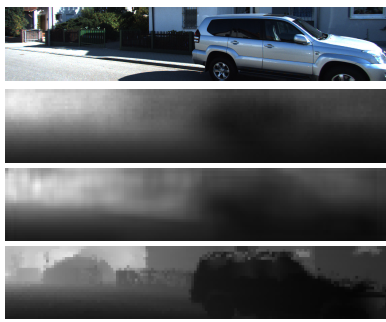

## Evaluation Results

In [ ]:
def compute_metrics(pred, gt, min_depth=1e-3, max_depth=80.0):
    """
    Compute all standard KITTI Eigen metrics:
      - AbsRel, SqRel
      - RMSE, RMSE_log
      - SIlog (scale-invariant)
      - delta1, delta2, delta3 accuracy thresholds
    """
    # Convert to float arrays
    gt = np.asarray(gt, np.float32)
    pred = np.asarray(pred, np.float32)

    # Use only valid depths (KITTI has holes, invalid values, sky areas)
    valid = np.isfinite(gt) & (gt > min_depth) & (gt < max_depth)
    if valid.sum() == 0:
        return [np.nan] * 8

    # Apply valid-mask
    gt   = gt[valid]
    pred = np.clip(pred[valid], min_depth, max_depth)

    # Absolute Relative Error
    abs_rel = np.mean(np.abs(gt - pred) / gt)

    # Squared Relative Error
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    # RMSE (linear)
    rmse = np.sqrt(np.mean((gt - pred) ** 2))

    # RMSE in log space
    rmse_log = np.sqrt(np.mean((np.log(gt) - np.log(pred)) ** 2))

    # Scale-Invariant log RMSE (from Eigen et al.)
    d = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(d**2) - (np.mean(d)**2))

    # Accuracy thresholds (delta metrics)
    ratio = np.maximum(gt / pred, pred / gt)
    delta1 = np.mean(ratio < 1.25)
    delta2 = np.mean(ratio < 1.25**2)
    delta3 = np.mean(ratio < 1.25**3)

    return abs_rel, sq_rel, rmse, rmse_log, silog, delta1, delta2, delta3

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_kitti(model, dataloader, device, use_fine=False, desc="Eval"):
    """
    Evaluate a model on KITTI-style data.

    - If use_fine=False: use coarse prediction.
    - If use_fine=True:  use fine prediction.
    """
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for rgb, depth in tqdm(dataloader, desc=desc):
            rgb   = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)

            # forward pass: EigenDepthModel returns (coarse, fine)
            out = model(rgb)
            if isinstance(out, (tuple, list)):
                coarse_pred, fine_pred = out
                pred = fine_pred if use_fine else coarse_pred
            else:
                # safety: if model only returns one output, treat as coarse
                pred = out

            # clamp and upsample to GT resolution
            pred = pred.clamp(1e-3, 80.0)
            pred_up = F.interpolate(
                pred, size=depth.shape[2:], mode="bilinear", align_corners=False
            )

            # per-image metrics
            for b in range(rgb.size(0)):
                p = pred_up[b, 0].cpu().numpy()
                g = depth[b, 0].cpu().numpy()
                all_metrics.append(compute_metrics(p, g))

    metrics_arr = np.array(all_metrics, np.float32)
    metrics_arr = metrics_arr[~np.isnan(metrics_arr).any(axis=1)]
    means = np.nanmean(metrics_arr, axis=0)

    names = ["AbsRel","SqRel","RMSE","RMSE_log","SIlog","Delta1","Delta2","Delta3"]

    print(f"\n--- {desc} ---")
    for n, v in zip(names, means):
        print(f"{n:12s}: {v:.4f}")

    return dict(zip(names, means))

In [ ]:
from torch.utils.data import DataLoader

eval_loader = DataLoader(val_dataset, batch_size=4, num_workers=0, shuffle=False)

# 1) Coarse column in Table 2 → coarse-only model, coarse output
metrics_coarse = evaluate_kitti(
    model_coarse, eval_loader, device,
    use_fine=False,
    desc="KITTI Coarse-only Model (Coarse output)"
)

# 2) Coarse + Fine column in Table 2 → fine-tuned model, FINAL fine output
metrics_coarse_fine = evaluate_kitti(
    model_fine, eval_loader, device,
    use_fine=True,
    desc="KITTI Coarse+Fine Model (Fine output)"
)

## Evaluation Results on KITTI dataset

In [ ]:
import pandas as pd

# Build a dictionary where each key is a metric (row)
# and each value is another dict of model → value
table = {
    "δ < 1.25": {
        "Coarse": metrics_coarse["Delta1"],
        "Coarse + Fine": metrics_coarse_fine["Delta1"],
    },
    "δ < 1.25²": {
        "Coarse": metrics_coarse["Delta2"],
        "Coarse + Fine": metrics_coarse_fine["Delta2"],
    },
    "δ < 1.25³": {
        "Coarse": metrics_coarse["Delta3"],
        "Coarse + Fine": metrics_coarse_fine["Delta3"],
    },
    "Abs Rel": {
        "Coarse": metrics_coarse["AbsRel"],
        "Coarse + Fine": metrics_coarse_fine["AbsRel"],
    },
    "Sq Rel": {
        "Coarse": metrics_coarse["SqRel"],
        "Coarse + Fine": metrics_coarse_fine["SqRel"],
    },
    "RMSE": {
        "Coarse": metrics_coarse["RMSE"],
        "Coarse + Fine": metrics_coarse_fine["RMSE"],
    },
    "RMSE log": {
        "Coarse": metrics_coarse["RMSE_log"],
        "Coarse + Fine": metrics_coarse_fine["RMSE_log"],
    },
    "RMSE (log, scale inv.)": {
        "Coarse": metrics_coarse["SIlog"],
        "Coarse + Fine": metrics_coarse_fine["SIlog"],
    }
}

# Build DataFrame
df_kitti = pd.DataFrame(table).T  # transpose → metrics as rows

# Round for neatness
df_kitti = df_kitti.round(4)

df_kitti

### Original Paper Obtained Results on KITTI dataset

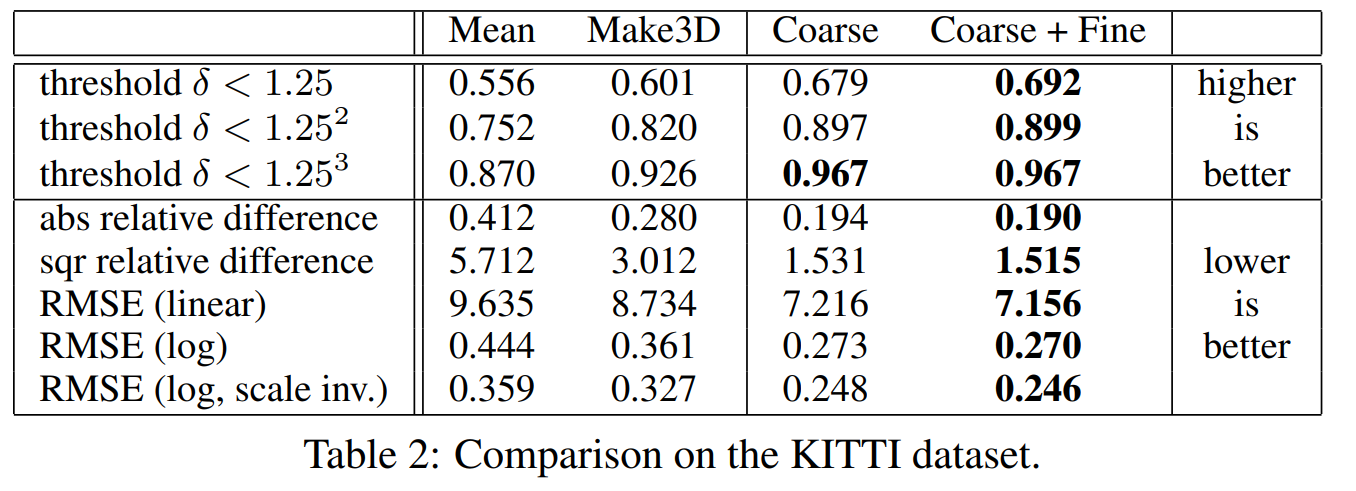